In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('../data_and_visualisation/HTRU_2.csv')
data.columns = ['Mean IP', 'Standard deviation IP', 'Excess kurtosis IP', 'Skewness IP',
                'Mean DS', 'Standard deviation DS', 'Excess kurtosis DS', 'Skewness DS',
                'Class']

In [3]:
x = data.drop('Class', axis = 'columns')
y = data['Class']

#### delimo podatke na trening i test skupove

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, stratify = y)

#### pravimo naivno stablo koje koristi CART algoritam da bismo ga kasnije poboljšali

In [5]:
stablo = DecisionTreeClassifier(class_weight = {0: y[y == 0].size, 1: y[y == 0].size})
model = stablo.fit(x_train, y_train)

In [6]:
def plot_decision_tree(model, feature_names, max_depth = 0):
    plt.figure(figsize = (40, 20))
    if(max_depth == 0):
        plot_tree(model, class_names = ['0', '1'], feature_names = feature_names, filled = True)
        plt.title("Stablo odlucivanja dubine {} sa ukupno {} krajnjih cvorova"
                  .format(model.get_depth(), model.get_n_leaves(), max_depth))
    else:
        plot_tree(model, class_names = ['0', '1'], feature_names = feature_names, filled = True, max_depth = max_depth)
        plt.title("Stablo odlucivanja dubine {} sa ukupno {} krajnjih cvorova (prikazano je samo prva {} sloja)"
                  .format(model.get_depth(), model.get_n_leaves(), max_depth))
    plt.show()

<Figure size 432x288 with 0 Axes>

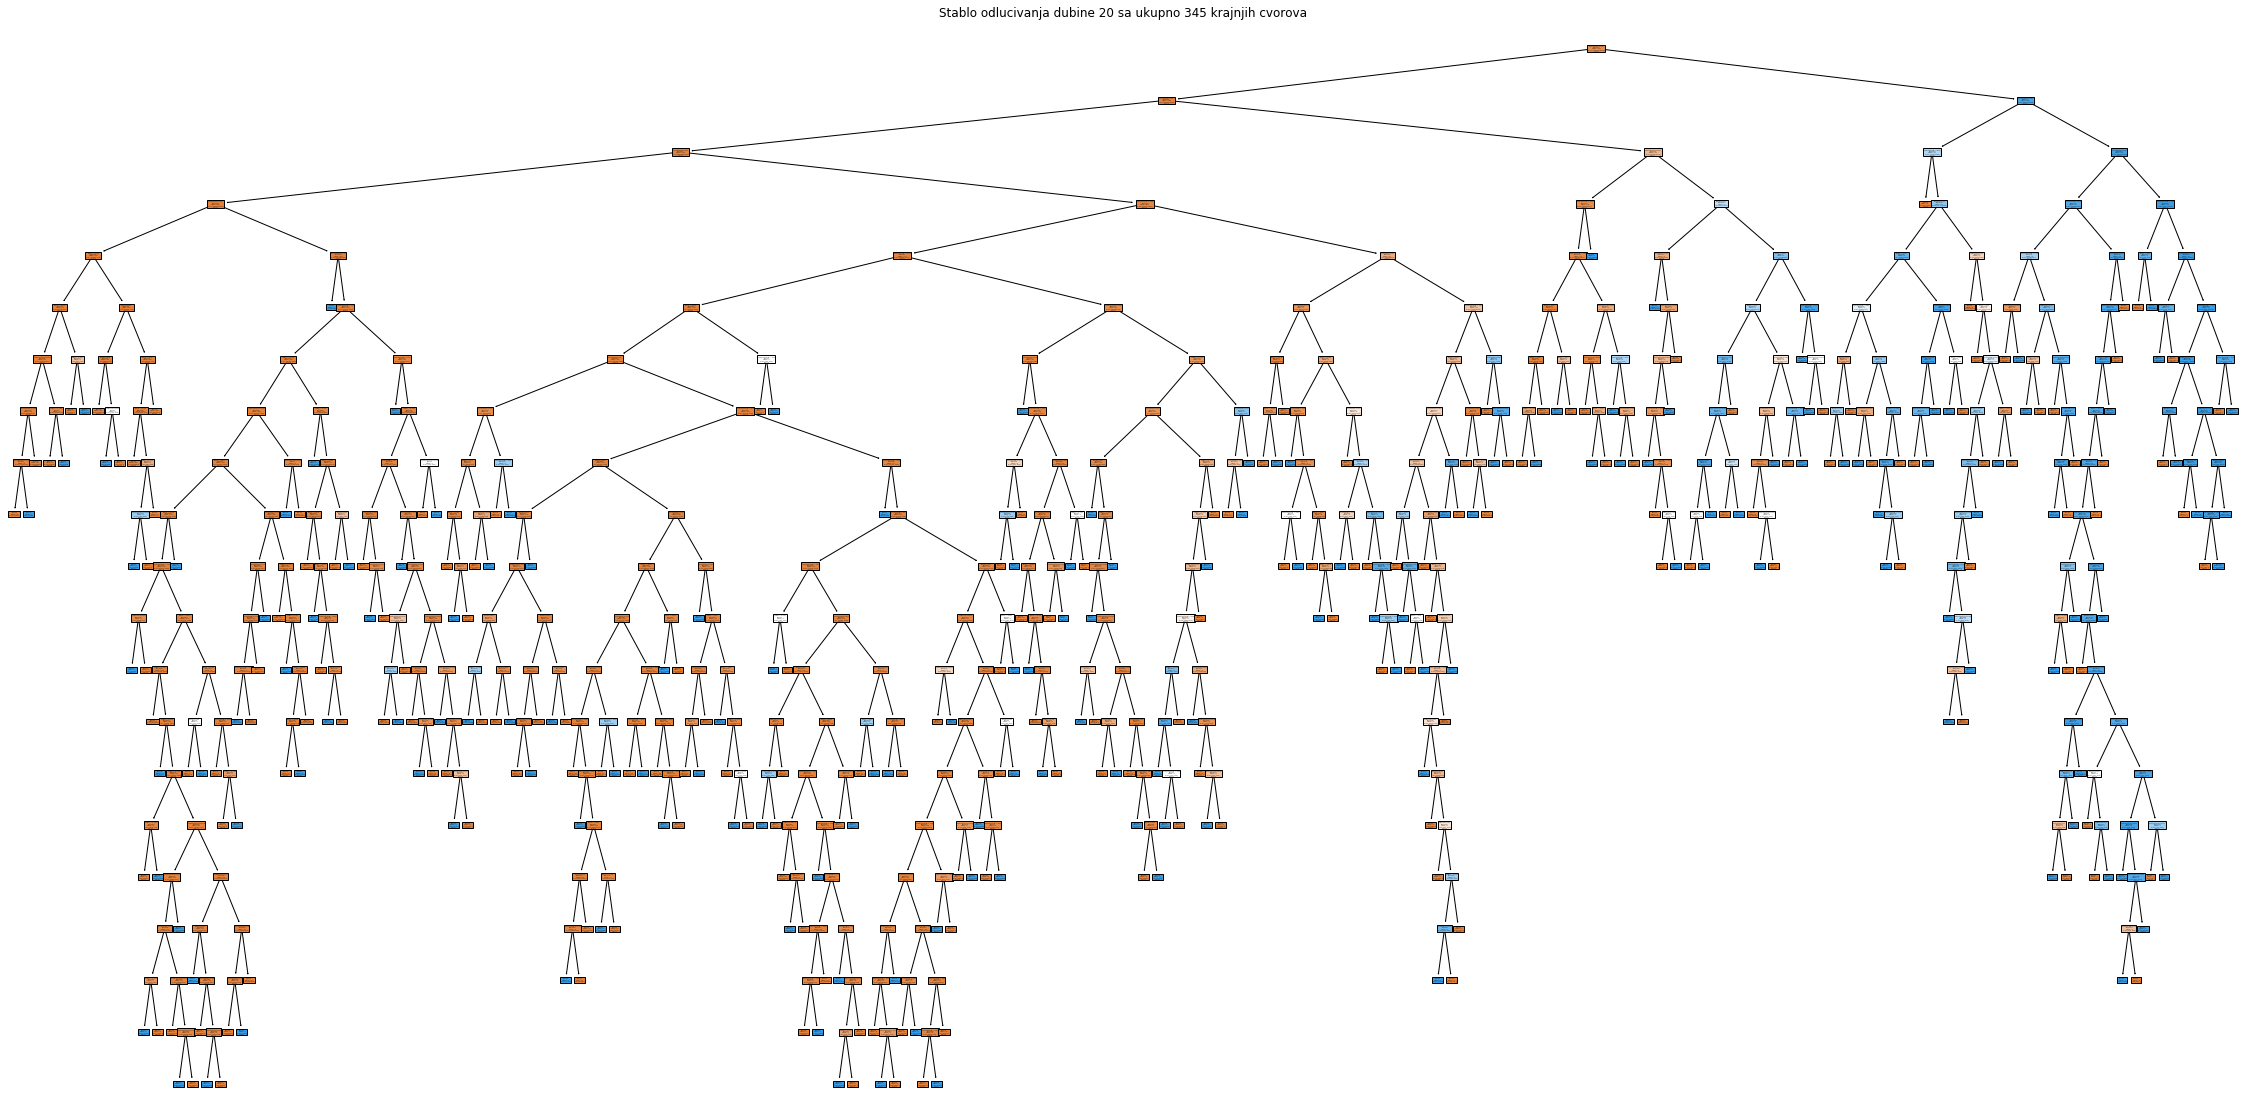

In [7]:
plt.figure()
plot_decision_tree(stablo, x.columns)
plt.show()

#### usput možemo pogledati koja kolona je najviše uticala na ovo stablo

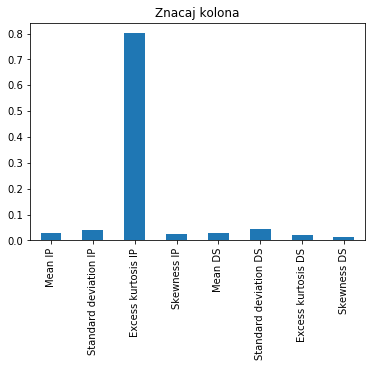

In [8]:
pd.Series(stablo.feature_importances_, index = x.columns).plot.bar()
plt.title("Znacaj kolona")
plt.show()

In [9]:
def matConf(model, x, y):
    y_pred = model.predict(x)
    return confusion_matrix(y, y_pred)

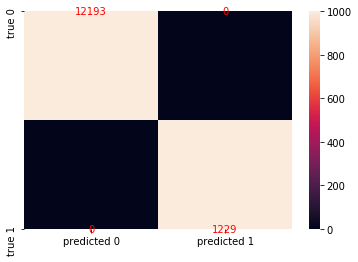

In [10]:
akws = {'c': 'red'}
sb.heatmap(matConf(stablo, x_train, y_train), xticklabels = ["predicted 0", "predicted 1"], yticklabels = ["true 0", "true 1"], annot = True, annot_kws = akws, fmt = 'g', vmin = 0, vmax = 1000)

#### ili imamo savršen model, ili će pre biti da smo ga pretrenirali

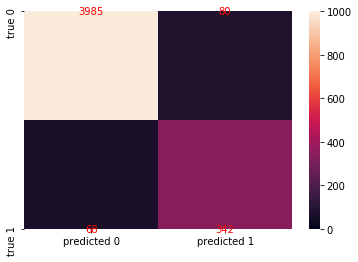

In [11]:
sb.heatmap(matConf(stablo, x_test, y_test), xticklabels = ["predicted 0", "predicted 1"], yticklabels = ["true 0", "true 1"], annot = True, annot_kws = akws, fmt = 'g', vmin = 0, vmax = 1000)

In [12]:
y_predict = model.predict(x_test)

Povrsina ispod krive: 0.9072


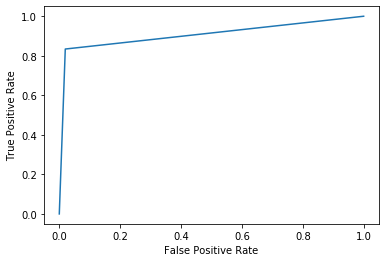

In [13]:
print("Povrsina ispod krive: %.4f" % roc_auc_score(y_test, y_predict))
fpr, tpr, _ = roc_curve(y_test, y_predict)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### pošto je model ipak pretreniran koristićemo GridSearchCV funkciju koja će naći najbolje parametre iz skupa koj zadamo
-  maksimalna dubina stabla - {3..11}
-  minimalan broj instanci u čvoru potreban da bi se on razgranao - {0, 20, 40, 60, 80, 100}
-  koliko minimalno mera nečistoće mora da se smanji prilikom potencijalnog grananja da bi se ono dozvolilo - {0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0}

In [14]:
hiperparametri = {
    'max_depth': range(3, 11),
    'min_samples_split': range(0, 101, 20)[1:],
    'min_impurity_decrease': np.linspace(0.0, 1.0, 11)
}
tabla = GridSearchCV(stablo, hiperparametri)

In [15]:
tabla.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight={0: 16258,
                                                            1: 16258}),
             param_grid={'max_depth': range(3, 11),
                         'min_impurity_decrease': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'min_samples_split': range(20, 120, 20)})

In [16]:
print("ispitano %d stabala" % len(tabla.cv_results_['params']))

ispitano 440 stabala


In [17]:
br_kandidata = np.count_nonzero(tabla.cv_results_['rank_test_score'] == 1)

In [18]:
if (br_kandidata%10 == 1):
    print("od toga %d kandidat" % np.count_nonzero(tabla.cv_results_['rank_test_score'] == 1))
else:
    print("od toga %d kandidata" % np.count_nonzero(tabla.cv_results_['rank_test_score'] == 1))

od toga 2 kandidata


In [19]:
pc = br_kandidata%10
if (pc == 1):
    print("najbolji kandidat: ")
elif (pc>1 and pc<5):
    print("najbolja %d kandidata: " % br_kandidata)
else:
    print("najboljih %d kandidata: " % br_kandidata)

rezultat = tabla.cv_results_
opt_parametri = {}
for i in range(1, br_kandidata+1):
    kandidati = np.flatnonzero(rezultat['rank_test_score'] == i)
    prvi = True
    for kandidat in kandidati:
        print("Model broj %d" % i)
        print("Mean validation score: %.3f std: %.3f" % (rezultat['mean_test_score'][kandidat], rezultat['std_test_score'][kandidat]))
        print("Parametri: %s" % rezultat['params'][kandidat])
        print("")
        if(prvi):
            opt_parametri = rezultat['params'][kandidat]
            prvi = False
            

najbolja 2 kandidata: 
Model broj 1
Mean validation score: 0.978 std: 0.002
Parametri: {'max_depth': 4, 'min_impurity_decrease': 0.0, 'min_samples_split': 20}

Model broj 1
Mean validation score: 0.978 std: 0.002
Parametri: {'max_depth': 4, 'min_impurity_decrease': 0.0, 'min_samples_split': 40}



#### sada možemo napraviti novo stablo sa dobijenim hiperparametrima

In [20]:
novoStablo = DecisionTreeClassifier(class_weight = {0: y[y == 0].size, 1: y[y == 0].size}, max_depth = opt_parametri['max_depth'], min_impurity_decrease = opt_parametri['min_impurity_decrease'], min_samples_split = opt_parametri['min_samples_split'])
noviModel = novoStablo.fit(x_train, y_train)


<Figure size 432x288 with 0 Axes>

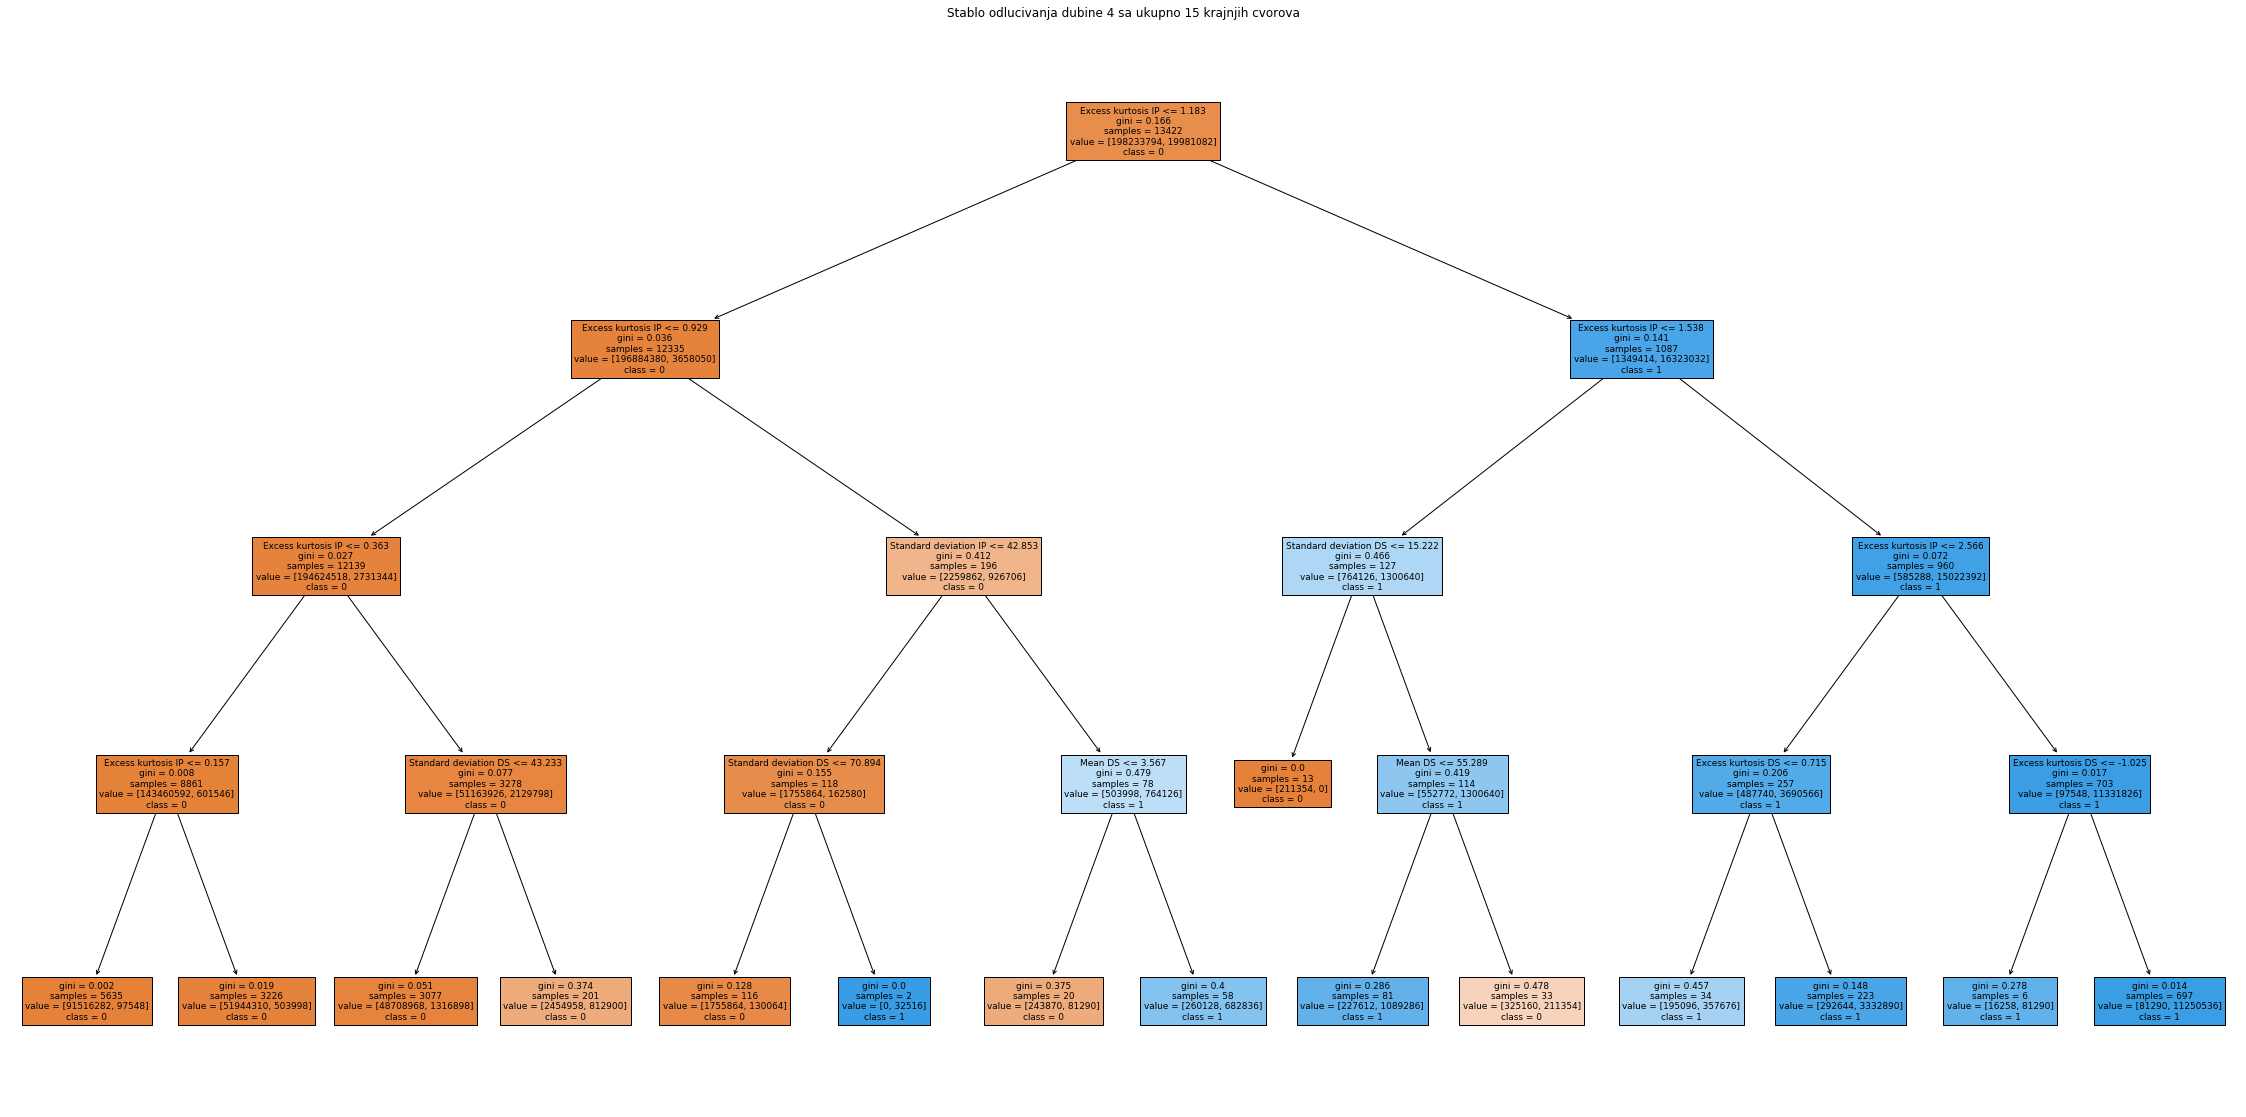

In [21]:
plt.figure()
plot_decision_tree(novoStablo, x.columns)
plt.show()

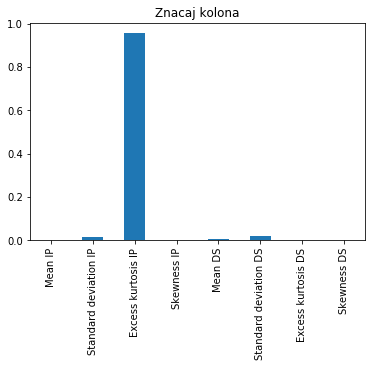

In [22]:
pd.Series(novoStablo.feature_importances_, index = x.columns).plot.bar()
plt.title("Znacaj kolona")
plt.show()

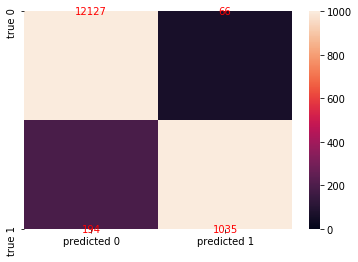

In [23]:
sb.heatmap(matConf(novoStablo, x_train, y_train), xticklabels = ["predicted 0", "predicted 1"], yticklabels = ["true 0", "true 1"], annot = True, annot_kws = akws, fmt = 'g', vmin = 0, vmax = 1000)


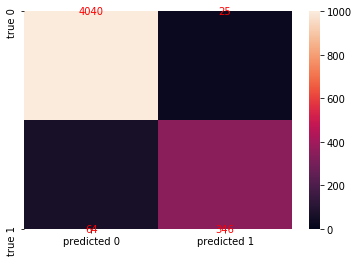

In [24]:
sb.heatmap(matConf(novoStablo, x_test, y_test), xticklabels = ["predicted 0", "predicted 1"], yticklabels = ["true 0", "true 1"], annot = True, annot_kws = akws, fmt = 'g', vmin = 0, vmax = 1000)


In [25]:
y_predict = noviModel.predict(x_test)

tacnost: 0.9801
preciznost: 0.9326
recall: 0.8439
f1: 0.8860
Povrsina ispod ROC krive: 0.9189
ROC kriva:


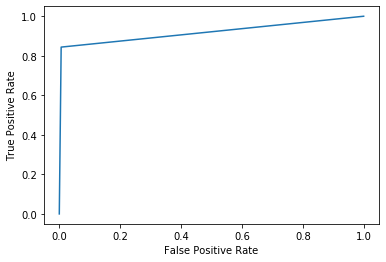

In [26]:
print("tacnost: %.4f" % accuracy_score(y_test, y_predict))
print("preciznost: %.4f" % precision_score(y_test, y_predict))
print("recall: %.4f" % recall_score(y_test, y_predict))
print("f1: %.4f" % f1_score(y_test, y_predict))
print("Povrsina ispod ROC krive: %.4f" % roc_auc_score(y_test, y_predict))
print("ROC kriva:")
fpr, tpr, _ = roc_curve(y_test, y_predict)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### dobili smo bolji model

#### ponovićemo isto koristeći metod slučajnih stabala, s tim što ćemo odmah tražiti optimalne hiperparametre

In [27]:
suma = RandomForestClassifier(n_jobs = -1, n_estimators = 25, class_weight = {0: y[y == 0].size, 1: y[y == 0].size})


In [28]:
hiperparametri = {
    'max_depth': range(1, 15),
    'min_samples_split': range(0, 101, 20)[1:],
    'min_impurity_decrease': np.linspace(0.0, 1.0, 11)
}
tabla = GridSearchCV(suma, hiperparametri)

In [29]:
tabla.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight={0: 16258, 1: 16258},
                                              n_estimators=25, n_jobs=-1),
             param_grid={'max_depth': range(1, 15),
                         'min_impurity_decrease': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'min_samples_split': range(20, 120, 20)})

In [30]:
print("ispitano %d stabala" % len(tabla.cv_results_['params']))

ispitano 770 stabala


In [31]:
br_kandidata = np.count_nonzero(tabla.cv_results_['rank_test_score'] == 1)

In [32]:
if (br_kandidata%10 == 1):
    print("od toga %d kandidat" % np.count_nonzero(tabla.cv_results_['rank_test_score'] == 1))
else:
    print("od toga %d kandidata" % np.count_nonzero(tabla.cv_results_['rank_test_score'] == 1))

od toga 1 kandidat


In [33]:
pc = br_kandidata%10
if (pc == 1):
    print("najbolji kandidat: ")
elif (pc>1 and pc<5):
    print("najbolja %d kandidata: " % br_kandidata)
else:
    print("najboljih %d kandidata: " % br_kandidata)

rezultat = tabla.cv_results_
for i in range(1, np.count_nonzero(rezultat['rank_test_score'] == 1)+1):
    kandidati = np.flatnonzero(rezultat['rank_test_score'] == i)
    for kandidat in kandidati:
        print("Model broj %d" % i)
        print("Mean validation score: %.3f std: %.3f)" % (rezultat['mean_test_score'][kandidat], rezultat['std_test_score'][kandidat]))
        print("Parametri: %s" % rezultat['params'][kandidat])
        print("")

najbolji kandidat: 
Model broj 1
Mean validation score: 0.979 std: 0.003)
Parametri: {'max_depth': 11, 'min_impurity_decrease': 0.0, 'min_samples_split': 20}



In [34]:
novaSuma = RandomForestClassifier(n_jobs = -1, n_estimators = 25, class_weight = {0: y[y == 0].size, 1: y[y == 0].size}, max_depth = opt_parametri['max_depth'], min_impurity_decrease = opt_parametri['min_impurity_decrease'], min_samples_split = opt_parametri['min_samples_split'])
noviModel2 = novaSuma.fit(x_train, y_train)

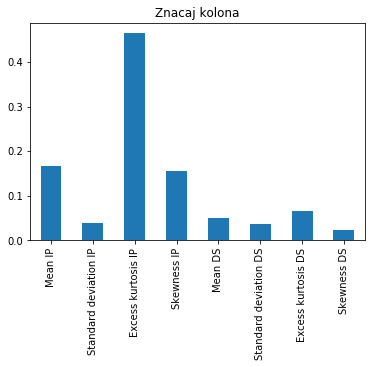

In [35]:
pd.Series(novaSuma.feature_importances_, index = x.columns).plot.bar()
plt.title("Znacaj kolona")
plt.show()

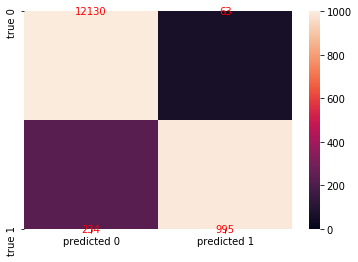

In [36]:
sb.heatmap(matConf(novaSuma, x_train, y_train), xticklabels = ["predicted 0", "predicted 1"], yticklabels = ["true 0", "true 1"], annot = True, annot_kws = akws, fmt = 'g', vmin = 0, vmax = 1000)


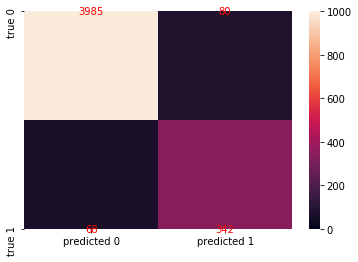

In [37]:
sb.heatmap(matConf(stablo, x_test, y_test), xticklabels = ["predicted 0", "predicted 1"], yticklabels = ["true 0", "true 1"], annot = True, annot_kws = akws, fmt = 'g', vmin = 0, vmax = 1000)


In [38]:
y_predict = noviModel2.predict(x_test)

tacnost: 0.9794
preciznost: 0.9392
recall: 0.8293
f1: 0.8808
Povrsina ispod ROC krive: 0.9119
ROC kriva:


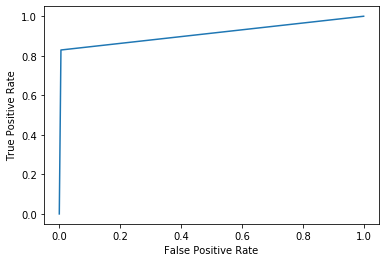

In [39]:
print("tacnost: %.4f" % accuracy_score(y_test, y_predict))
print("preciznost: %.4f" % precision_score(y_test, y_predict))
print("recall: %.4f" % recall_score(y_test, y_predict))
print("f1: %.4f" % f1_score(y_test, y_predict))
print("Povrsina ispod ROC krive: %.4f" % roc_auc_score(y_test, y_predict))
print("ROC kriva:")
fpr, tpr, _ = roc_curve(y_test, y_predict)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### na ovim podacima najbolje sto šmo postigli je CARTov algoritam drveta odlučivanja sa nađenim hiperparametrima